### Imports

In [5]:
from zipfile import ZipFile
from sklearn.metrics import accuracy_score, recall_score, precision_score, \
f1_score, roc_auc_score, roc_curve, auc, confusion_matrix, classification_report
import string
from sklearn.model_selection import train_test_split
import os
import statistics
import shutil
import matplotlib
import re
import warnings
from catboost import CatBoostClassifier, cv
import catboost
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
np.printoptions(pricision=2)
import pandas as pd
import itertools
pd.set_option('display.max_columns', 30)
# %matplotlib inline
warnings.filterwarnings('ignore')
# nltk.download('stopwords')
plt.style.use('ggplot')
from scipy.stats.contingency import chi2_contingency
from sklearn.feature_selection import chi2, SelectKBest, f_classif
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import boxcox, skew, kurtosis, normaltest
from sklearn.decomposition import PCA
import sklearn.impute
from catboost import Pool
import pickle

<h4>This code reads training and testing data from CSV files, assigns a label 'is_train' to distinguish between them, and combines them into a single DataFrame named 'df'. <br/> The 'dtype' and 'parse_dates' parameters are used for specifying data types and date parsing, respectively. This code prepares the data for further analysis or modeling.</h4>

In [7]:
dtypes = dict(
    Month="category",
    Name="category",
    Occupation="category",
    Type_of_Loan="category",
    Credit_History_Age="category",
    Payment_Behaviour="category"
)


train_df = pd.read_csv("csvs/train.csv", dtype=dtypes, parse_dates=['Month'])
train_df["is_train"] = True
test_df = pd.read_csv("csvs/test.csv", dtype=dtypes, parse_dates=['Month'])
test_df["is_train"] = False
df = pd.concat([train_df, test_df])
df.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score,is_train
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7,11.27,4.0,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good,True
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",-1,NaN,11.27,4.0,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good,True
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7,_,4.0,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good,True
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",5,4,6.27,4.0,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good,True
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",6,NaN,11.27,4.0,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good,True


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 150000 entries, 0 to 49999
Data columns (total 29 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   ID                        150000 non-null  object  
 1   Customer_ID               150000 non-null  object  
 2   Month                     150000 non-null  object  
 3   Name                      135000 non-null  category
 4   Age                       150000 non-null  object  
 5   SSN                       150000 non-null  object  
 6   Occupation                150000 non-null  category
 7   Annual_Income             150000 non-null  object  
 8   Monthly_Inhand_Salary     127500 non-null  float64 
 9   Num_Bank_Accounts         150000 non-null  int64   
 10  Num_Credit_Card           150000 non-null  int64   
 11  Interest_Rate             150000 non-null  int64   
 12  Num_of_Loan               150000 non-null  object  
 13  Type_of_Loan              132888 no

In [9]:
df.isna().sum().sum

<bound method Series.sum of ID                              0
Customer_ID                     0
Month                           0
Name                        15000
Age                             0
SSN                             0
Occupation                      0
Annual_Income                   0
Monthly_Inhand_Salary       22500
Num_Bank_Accounts               0
Num_Credit_Card                 0
Interest_Rate                   0
Num_of_Loan                     0
Type_of_Loan                17112
Delay_from_due_date             0
Num_of_Delayed_Payment      10500
Changed_Credit_Limit            0
Num_Credit_Inquiries         3000
Credit_Mix                      0
Outstanding_Debt                0
Credit_Utilization_Ratio        0
Credit_History_Age          13500
Payment_of_Min_Amount           0
Total_EMI_per_month             0
Amount_invested_monthly      6750
Payment_Behaviour               0
Monthly_Balance              1762
Credit_Score                50000
is_train            

In [13]:
np.unique(df["Credit_Mix"])

array(['Bad', 'Good', 'Standard', '_'], dtype=object)

In [14]:
df.drop(["Name", "SSN", "ID"], axis=1, inplace=True, errors="ignore") # Dropping irrelevant columns

#### Find distinct values in categorical columns.

In [19]:
def get_unique_values(df):
    """
    Get unique values and their counts in categorical columns of a DataFrame.

    Parameters:
    df (pd.DataFrame): The input DataFrame with categorical columns.

    Returns:
    pd.DataFrame: A summary of unique values in categorical columns including:
        - 'column': The column name.
        - 'unique': List of unique values.
        - 'counts': List of counts for each unique value.
        - 'len_unique_values': Number of unique values in the column.
        - '%_unique_values': Percentage of each unique value in the column.

    Note:
    - Columns with more than 5000 unique values are excluded.
    """
    cat_cols = df.select_dtypes("object").columns

    data_info = np.zeros((len(cat_cols), 5), dtype="object")
    for i, col in enumerate(cat_cols):
          
        # Uses 5000 threshold to exclude columns with an excessive number of unique values. 
        # This makes the output more manageable and focused on relevant categorical columns. 
        # Adjust the threshold as needed.
        
        if len(df[col].unique()) > 5000:
            continue
        else:
            unique_values, counts = np.unique(
                np.array(df[col], dtype=str), return_counts=True)
            num_of_uv = len(unique_values)
            unique_val_percent = np.round(counts / counts.sum(), 2)
            data_info[i, :] = [col, unique_values.tolist(
            ), counts.tolist(), num_of_uv, unique_val_percent]
    return pd.DataFrame(data_info, columns=["column", "unique", "counts", "len_unique_values", "%_unique_values"])


In [20]:
unique_values_df = get_unique_values(df)
unique_values_df.head()

,column,unique,counts,len_unique_values,%_unique_values
0,0,0,0,0,0
1,Month,"[April, August, December, February, January, J...","[12500, 12500, 12500, 12500, 12500, 12500, 125...",12,"[0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.0..."
2,Age,"[-500, 100, 1004, 1006, 1007, 1010, 1018_, 102...","[1350, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2524,"[0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,0,0,0,0,0
4,Num_of_Loan,"[-100, 0, 0_, 1, 100, 1001, 1002, 1006, 1008, ...","[5850, 15543, 833, 15112, 1, 1, 1, 1, 1, 1, 1,...",623,"[0.04, 0.1, 0.01, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0..."


#### Data Processing with the DataProcessor Class

This Python code defines a versatile DataProcessor class for efficiently preprocessing and cleaning data within a DataFrame. The class includes several methods, each designed to perform specific data cleaning and transformation tasks:

<ul>
<li>get_month: This method extracts and calculates months from date-like strings found in the data.</li><br/>

<li>get_numbers: A static method that extracts numerical values from text strings, useful for cleaning columns containing mixed data.</li><br/>

<li>replace_special_character: Another static method that replaces special characters and handles specific cases like "NM" and "payments."</li><br/>

<li>preprocess_text: This static method tokenizes and processes text data, creating a dictionary of unique tokens and returning cleaned, tokenized strings.</li><br/>

<li>fill_na: This method fills missing values in categorical and numerical columns based on a specified grouping.</li><br/>

<li>preprocess: The main preprocessing method of the class. It applies a series of transformations to the DataFrame, such as extracting numbers from the 'Age' column, applying the replace_special_character function to the entire DataFrame, handling 'Credit_Mix' and 'Payment_Behaviour' columns, tokenizing 'Type_of_Loan' values, converting 'Credit_History_Age' values, and handling missing values with the fill_na method.</li><br/>
</ul>
<br/>
By using the DataProcessor class, you can efficiently prepare your data for analysis or modeling tasks, ensuring that it's clean, structured, and ready for further exploration. The class provides reusable methods for common data preprocessing challenges, making it a valuable tool in your data analysis workflow.

In [21]:
class DataProcessor:

    def __init__(self, groupby, data_frame):
        self.groupby = groupby
        self.df = data_frame


    def get_month(self, x):
     if not pd.isnull(x):
         year_month = re.findall(r"\d+", x)
         months = (int(year_month[0])*12) + np.int64(year_month[-1])
         return months
     else:
         x

    @staticmethod
    def get_numbers(text):
        digits = re.findall(r'\d+', str(text))
        digits = ','.join(digits)
        return digits

    @staticmethod
    def replace_special_character(text):
        if "NM" in str(text):
            return "No"

        if "payments" in str(text) or "_" not in str(text):
            return text

        clean_text = str(text).replace("_", "")
        return np.nan if clean_text == "nan" else clean_text

    @staticmethod
    def preprocess_text(texts:str) -> tuple[dict, list[list[str]]]:
        dictionary = {}

        tokens = [str(text).lower().replace("and", "").split(",") for text in texts]
        tokens = [[token.strip() for token in token_list if token not in string.punctuation] for token_list in tokens]
        for token_list in tokens:
            for token in token_list:
                if token not in dictionary:
                    size = len(dictionary)
                    dictionary[token] = size
        return (dictionary, ["|".join(words) for words in tokens])


    @staticmethod
    def fill_na(df: pd.DataFrame, groupby=None):
        cat_features = df.select_dtypes(exclude="number").columns.drop(
            ["is_train", "Credit_Score", "Type_of_Loan"])
        num_features = df.select_dtypes(include="number").columns

        df["Type_of_Loan"].fillna("not specified", inplace=True)

        def fill_na_cat(df):
            df[cat_features] = df.groupby(groupby)[cat_features].transform(
                lambda x: x.fillna(x.mode()[0]))
            return df

        def fill_na_num(df):
            df[num_features] = df.groupby(groupby)[num_features].transform(
                lambda x: x.fillna(x.median()))
            return df

        df = fill_na_cat(df)
        df = fill_na_num(df)
        return df


    def preprocess(self):
        self.df['Age'] = self.df.Age.apply(DataProcessor.get_numbers)
        self.df = self.df.applymap(DataProcessor.replace_special_character)
        self.df = self.df.apply(lambda x: pd.to_numeric(x, errors="ignore"))
        self.df["Credit_Mix"] = self.df.groupby(self.groupby)["Credit_Mix"].transform(lambda x: x.replace("", x.mode()[0]))
        self.df["Payment_Behaviour"] = self.df.groupby(self.groupby)["Payment_Behaviour"].transform(
            lambda x: x.replace("!@9#%8" if x.mode()[0] != "@9#%8" else np.nan)
        )
        self.df["Type_of_Loan"] = self.df[["Type_of_Loan"]].apply(lambda x:  DataProcessor.preprocess_text(x.values)[-1])
        self.df["Type_of_Loan"] = self.df["Type_of_Loan"].str.replace(" ", "_").str.replace("|", " ")
        self.df["Credit_History_Age"] = self.df["Credit_History_Age"].apply(lambda x: self.get_month(x))
        self.df["Monthly_Balance"] = pd.to_numeric(self.df.Monthly_Balance, errors="coerce")
        self.df = DataProcessor.fill_na(self.df, "Customer_ID")

        return self.df

In [39]:
preprocesor = DataProcessor("Customer_ID", df)
data = preprocesor.preprocess()

In [40]:
data.loc[df["Num_Bank_Accounts"]<0, "Num_Bank_Accounts"] = 0  # Replacing account balances less than zero with zero
data.loc[data["Type_of_Loan"]=="nan", "Type_of_Loan"] = np.nan  #Replace "nan" values in the 'Type_of_Loan' column with NaN for consistency
data.loc[data["Occupation"] == "", "Occupation"] = np.nan  #Replace "nan" values in the 'Occupation' column with NaN for consistency
data.loc[data["Credit_Mix"] == "", "Credit_Mix"] = np.nan  #Replace "nan" values in the 'Credit_Mix' column with NaN for consistency

### Custom Outlier Removal and Skewness Correction

The provided Python code defines a ClipOutliersTransformer class and functions for outlier removal and skewness correction within a pandas DataFrame.
<ul>
<li>ClipOutliersTransformer Class: This class is designed to transform numerical data by clipping outliers. It takes parameters such as lower and upper quantiles, a multiplier for defining the clipping limits, and an option to replace outliers with the median. The fit method calculates the lower and upper clipping limits based on quantiles, and the transform method applies the clipping transformation.</li> <br/>

<li>get_skewness Function: This function calculates the skewness of numerical columns in a DataFrame and categorizes them as highly skewed or lowly skewed based on user-defined skewness thresholds.</li><br/>

<li>remove_outliers Function: This function is used to remove outliers and correct skewness in numerical columns of a DataFrame. It first identifies highly and lowly skewed columns using the get_skewness function. Then, it applies the ClipOutliersTransformer to clip outliers in highly skewed columns while replacing them with the median, and to clip outliers in lowly skewed columns without replacement.</li><br/>
</ul>
These tools collectively provide a flexible and customizable approach to handling outliers and skewness in your dataset, allowing for improved data quality and more accurate analysis or modeling.

In [41]:
class ClipOutliersTransformer(BaseEstimator, TransformerMixin):

    def __init__(self,
                 lower_quantile,
                 upper_quantile,
                 multiply_by=1.5,
                 replace_with_median: bool = False):
        self.lower_quantile = lower_quantile
        self.upper_quantile = upper_quantile
        self.multiply_by = multiply_by
        self.replace_with_median = replace_with_median

        self.lower_limit = 0
        self.upper_limit = 0
        self.feature_names_in_ = None

    def fit(self, X, y=None):
        q1, q3 = np.quantile(X, [self.lower_quantile, self.upper_quantile])
        iqr = q3 - q1
        self.lower_limit = q1 - (self.multiply_by * iqr)
        self.upper_limit = q3 + (self.multiply_by * iqr)
        # self.feature_names_in_ = X.columns.tolist()

        return self

    def transform(self, X):
        if self.replace_with_median:
            return np.where(
                ((X >= self.lower_limit) & (X <= self.upper_limit)), X,
                np.median(X))
        else:
            return np.clip(X, self.lower_limit, self.upper_limit)


def get_skewness(df, lower=None, upper=None):
    columns = df.columns
    skewness: pd.Series = df[columns].skew()
    highly_skewed = skewness[(skewness <= lower) |
                             (skewness >= upper)].index.to_list()
    lowly_skewed = skewness[(skewness > lower)
                            & (skewness < upper)].index.to_list()
    return (highly_skewed, lowly_skewed)


def remove_outliers(df: pd.DataFrame):
    category = df.select_dtypes(exclude="number").columns.drop(
        ["Credit_Score"])
    numbers = df.select_dtypes(include="number").columns

    highly_skewed, lowly_skewed = get_skewness(df[numbers],
                                               lower=-0.8,
                                               upper=0.8)

    df[highly_skewed] = df[highly_skewed].apply(
        lambda x: ClipOutliersTransformer(
            0.25, 0.75, multiply_by=1.5, replace_with_median=True).
        fit_transform(x))

    df[lowly_skewed] = df[lowly_skewed].apply(
        lambda x: ClipOutliersTransformer(
            0.25, 0.75, multiply_by=1.5, replace_with_median=False).
        fit_transform(x))
    return df

In [42]:
data = remove_outliers(data)

In [43]:
def make_boxplot(df, column, ax):
    sns.boxplot(x="Credit_Score", y=column, data=df, ax=ax, width=0.8, palette="Set2")
    plt.xticks(rotation=90)
    # add the five number summary to the plot
    plt.title(column, fontdict={"fontsize": 10})
    plt.xticks(rotation=0)

In [44]:
matplotlib.rc(("xtick", "ytick", "text"), c="k")
matplotlib.rc("figure", dpi=80)

In [45]:
def plot_boxplot_num_cols(df):
    fig = plt.figure(figsize=(18, 14), dpi=300)
    numb_columns = df.select_dtypes(include="number").columns
    for column in numb_columns:
        ax = fig.add_subplot(5, 4, list(numb_columns).index(column)+1)
        make_boxplot(df, column, ax)
        plt.tight_layout(pad=0.3)
    plt.tight_layout()
    plt.show()

### Data Visualization with Box Plots and Intuition
The provided Python code defines functions for creating box plots, which are a powerful visualization tool for understanding the distribution of numerical data.

<ul>
<li>Box Plots Intuition: Box plots provide a graphical representation of the data's central tendency, spread, and potential outliers. The "box" in the plot represents the interquartile range (IQR), which encompasses the middle 50% of the data. The line inside the box denotes the median (50th percentile), while the "whiskers" extend to the minimum and maximum values within a defined range or to the nearest data points within a certain distance from the quartiles. Any data points outside the whiskers are considered outliers and are plotted individually.</li><br/>

<li>make_boxplot Function: This function creates a box plot for a specified numerical column against the 'Credit_Score' column in the DataFrame. It allows us to visually assess how the values of a particular numerical variable are distributed within different credit score groups.</li><br/>

<li>plot_boxplot_num_cols Function: This function automates the creation of multiple box plots for all numerical columns in the DataFrame, making it easier to compare the distributions of various numerical features.</li>
</ul>
<br/>

By using box plots, you can quickly identify potential outliers, assess the central tendency and spread of data, and gain insights into the overall distribution of numerical variables, aiding in data exploration and decision-making in data analysis and modeling.

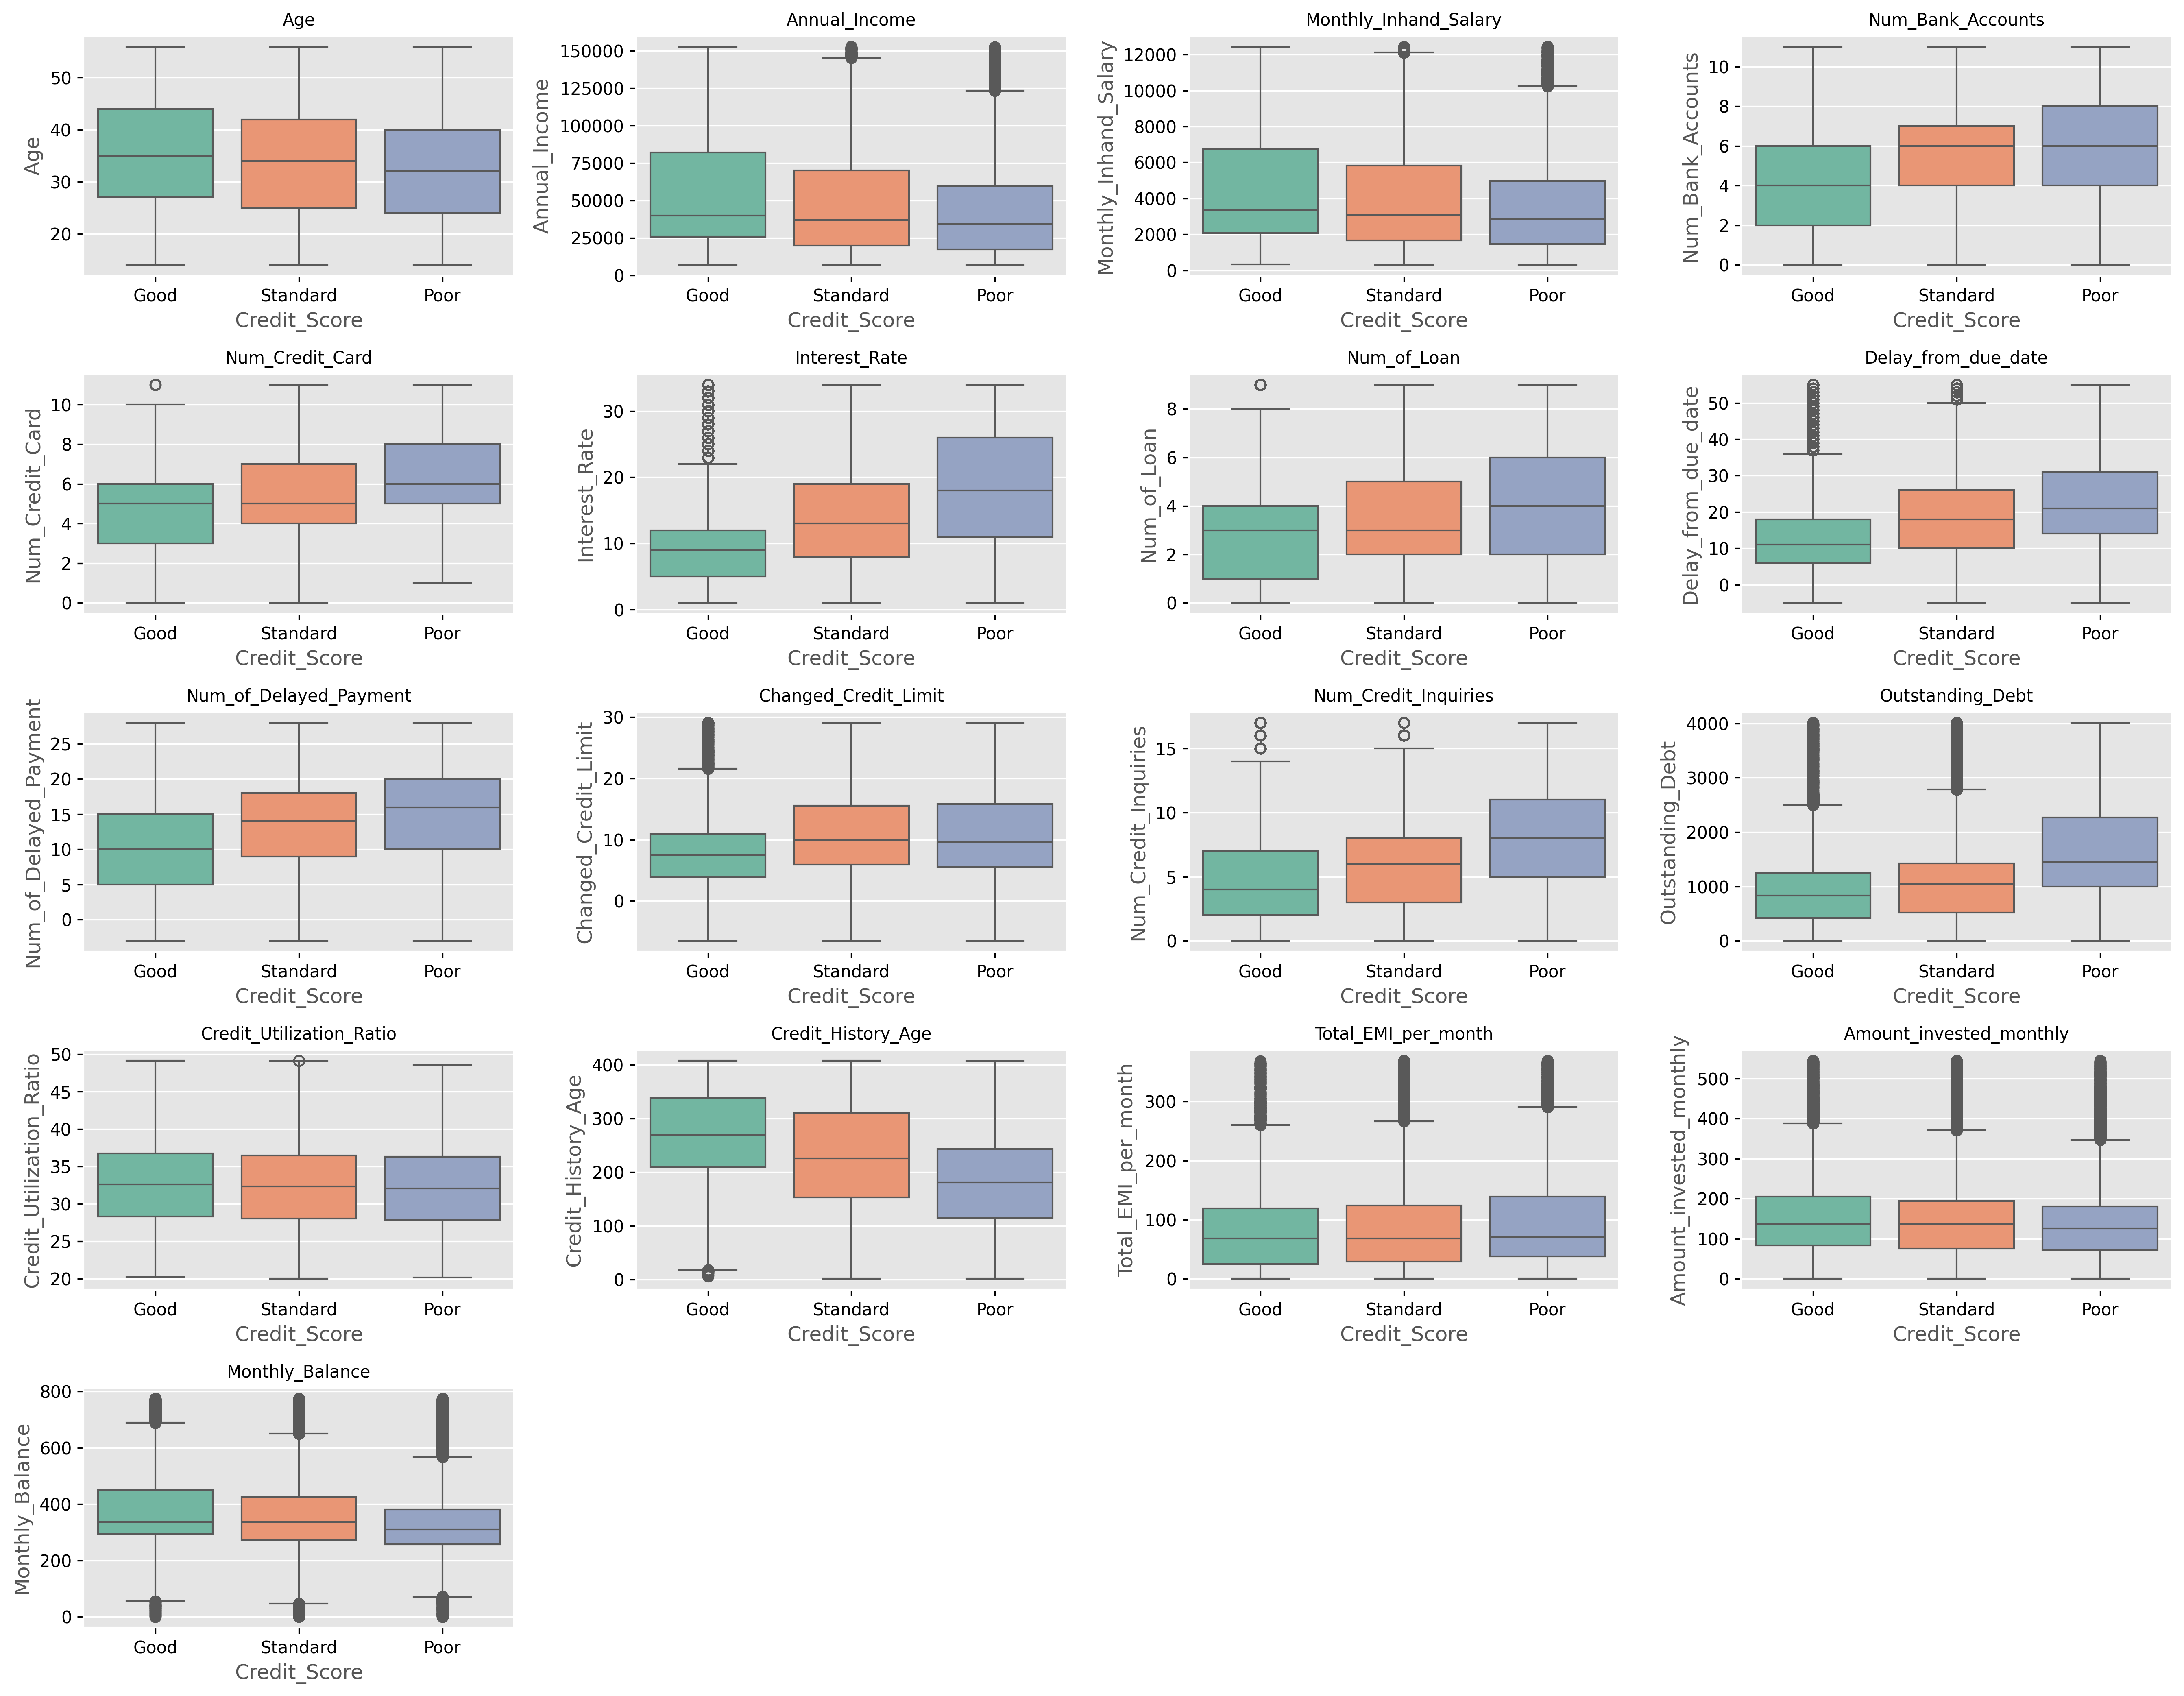

In [46]:
plot_boxplot_num_cols(data)

ValueError: cannot reindex on an axis with duplicate labels

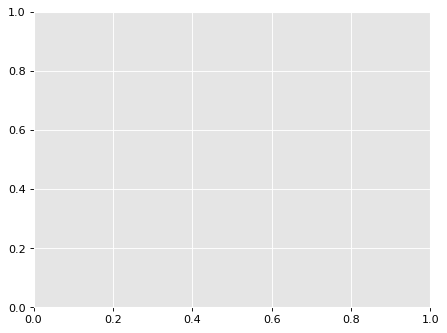

In [48]:
sns.countplot(data=data, x="Credit_Mix", hue="Credit_Score")

In [50]:
data.to_csv("csvs/clean_data_credit.csv", index=False)
"clean_data_credit.csv" in os.listdir()

True

In [52]:
df = pd.read_csv("clean_data_credit.csv")
df_copy = data.copy()
df_copy["Monthly_Balance"] = df_copy.groupby("Customer_ID")["Monthly_Balance"].transform(lambda x: np.where((x>np.quantile(x, 0.75)) | x<np.quantile(x, 0.75), np.median(x), x))

In [53]:
cross_tab = pd.crosstab(values=df_copy["Monthly_Balance"], index=[
                        df_copy["Credit_Score"], df_copy["Credit_Mix"]], columns="Monthly_Balance", aggfunc="mean").reset_index()

main_group = pd.pivot_table(cross_tab, "Monthly_Balance", "Credit_Score", aggfunc=np.mean)
cross_tab

col_0,Credit_Score,Credit_Mix,Monthly_Balance
0,Good,Bad,296.320348
1,Good,Good,403.335501
2,Good,Standard,387.642526
3,Poor,Bad,300.345681
4,Poor,Good,401.109600
5,Poor,Standard,343.470179
6,Standard,Bad,290.381714
7,Standard,Good,397.612596
8,Standard,Standard,387.203665


In [55]:
b = plt.cm.Blues
a = plt.cm.Accent
k = plt.cm.Blues(100, 0.9)

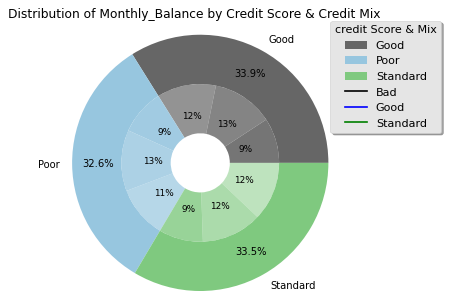

In [56]:
fig, ax = plt.subplots(figsize=(6, 4))
fig.suptitle("Distribution of Monthly_Balance by Credit Score & Credit Mix",
             fontsize=11,
             color="k")
# fig.patch.set_alpha(0)
# fig.patch.set_facecolor("#ff9999")
fig.set_frameon(True)

pie1, *_, texts = ax.pie(x=main_group["Monthly_Balance"],
                         labels=main_group.index,
                         autopct="%.1f%%",
                         radius=1.3,
                         colors=[a(80, 1), b(100, 1),
                                 a(0, 1)],
                         pctdistance=0.8,
                         textprops={"size": 9},
                         frame=True)
plt.setp(pie1, width=0.5)
ax.set_frame_on(True)

pie2, *_, texts = ax.pie(x=cross_tab["Monthly_Balance"],
                         autopct="%.0f%%",
                         radius=0.8,
                         colors=[
                             a(80, 0.9),
                             a(80, 0.8),
                             a(80, 0.7),
                             b(100, 0.9),
                             b(100, 0.8),
                             b(100, 0.7),
                             a(0, 0.8),
                             a(0, 0.65),
                             a(0, 0.5)
],
    textprops={"size": 8})
plt.setp(pie2, width=0.5)
legend_labels = np.unique(cross_tab["Credit_Mix"])

legend_handles = [
    plt.plot([], label=legend_labels[0], c="k"),
    plt.plot([], label=legend_labels[1], c='b'),
    plt.plot([], label=legend_labels[-1], c="g")
]
plt.legend(shadow=True,
           frameon=True,
           facecolor="inherit",
           loc="best",
           title="credit Score & Mix",
           bbox_to_anchor=(1, 1, 0.5, 0.1))

plt.show()

In [57]:
def make_countplot(df: pd.DataFrame):

    cat_cols = df.select_dtypes(exclude="number").columns.drop(
        ['Credit_Score', 'is_train', 'Customer_ID', "Type_of_Loan"])
    cat_cols = list(cat_cols)
    cat_cols.pop(-1)
    cat_cols.insert(-2, "Payment_Behaviour")

    fig, axes = plt.subplots(figsize=(12, 6), dpi=300)
    fig.suptitle("Counts of categorical columns")
    axes.grid(visible=False)
    axes.xaxis.set_tick_params(labelbottom=False)
    axes.yaxis.set_tick_params(labelleft=False)

    def __plot_graph(df, col, ax: plt.Axes, legend=False):
        sns.countplot(
            data=df,
            x=col,
            ax=ax,
            hue="Credit_Score",
        )
        # label =ax.get_xlabel()
        ax.set_xlabel(col, fontdict={"size": 9})
        ax.set_title(f"by {col}", fontdict={"size": 9})
        ax.get_xticklabels()
        ax.tick_params(labelsize=7, axis="y")
        ax.set_xticklabels(ax.get_xticklabels(),
                           rotation=90,
                           fontdict=dict(size=7))
        ax.grid(False)
        if legend:
            ax.legend(shadow=True,
                      loc="best",
                      facecolor="inherit",
                      frameon=True)
        else:
            ax.legend_ = None
        plt.tight_layout(w_pad=1)

    for i, col in enumerate(cat_cols, 1):
        if i == 3:
            continue
        ax = fig.add_subplot(2, 3, i)
        __plot_graph(df, col=col, ax=ax)

    ax2 = fig.add_axes((0.74, 0.527, 0.23, 0.35))
    __plot_graph(df, col="Payment_Behaviour", ax=ax2, legend=True)
    plt.show(True)

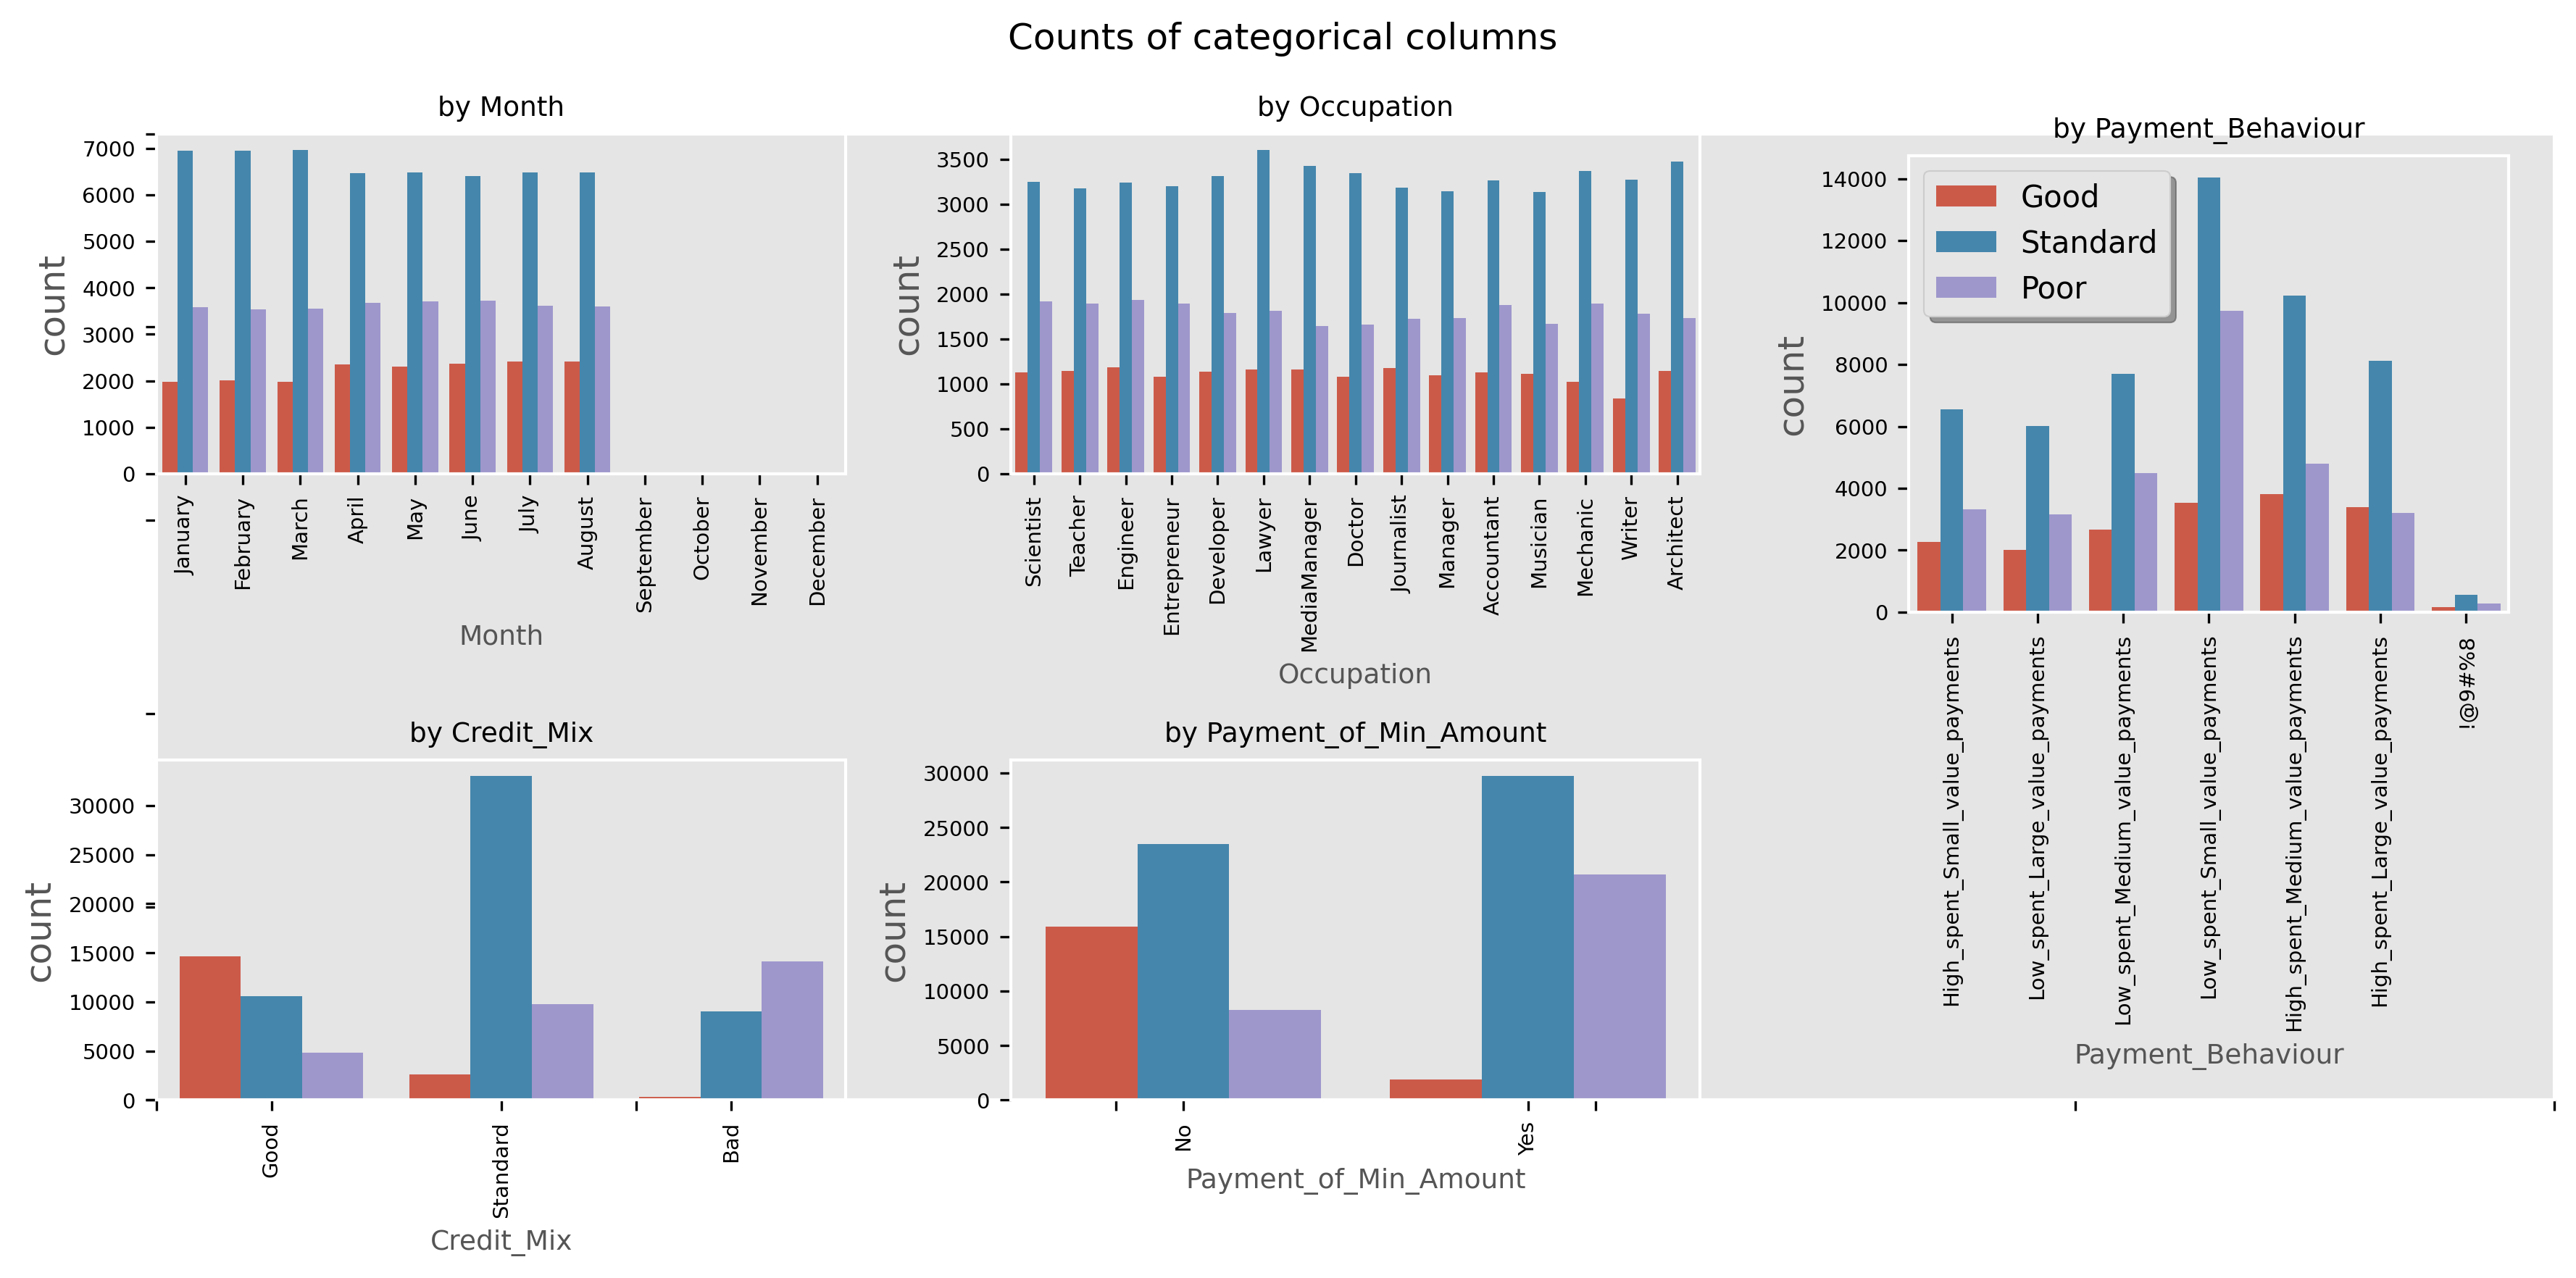

In [58]:
make_countplot(df)

### Correlation Heatmap and Intuition
The provided Python code calculates and visualizes the correlation matrix of numerical features in the dataset, excluding the "is_train" column. Here's the intuition behind the code:

Correlation Matrix: The code computes a correlation matrix (corr) that quantifies the linear relationships between pairs of numerical features. Each cell in the matrix represents the correlation coefficient, which can range from -1 (perfect negative correlation) to 1 (perfect positive correlation), with 0 indicating no correlation.

Masking the Upper Triangle: To enhance clarity, the code applies a mask (mask) to hide the upper triangular part of the matrix. This is because the correlation matrix is symmetric, and the upper triangle contains redundant information.

Heatmap Visualization: The sns.heatmap function from the Seaborn library is used to create a heatmap of the correlation matrix. Annotations in the heatmap display the correlation coefficients as percentages. The resulting visualization provides a quick overview of how numerical features relate to each other, helping identify strong correlations (either positive or negative) and potential multicollinearity in the data.

Intuition: By examining the heatmap, you can gain insights into which pairs of features are highly correlated. Positive correlations suggest that when one feature increases, the other tends to increase as well, while negative correlations indicate an inverse relationship. Understanding these relationships can inform feature selection, identify redundant features, and guide feature engineering during data analysis or modeling.

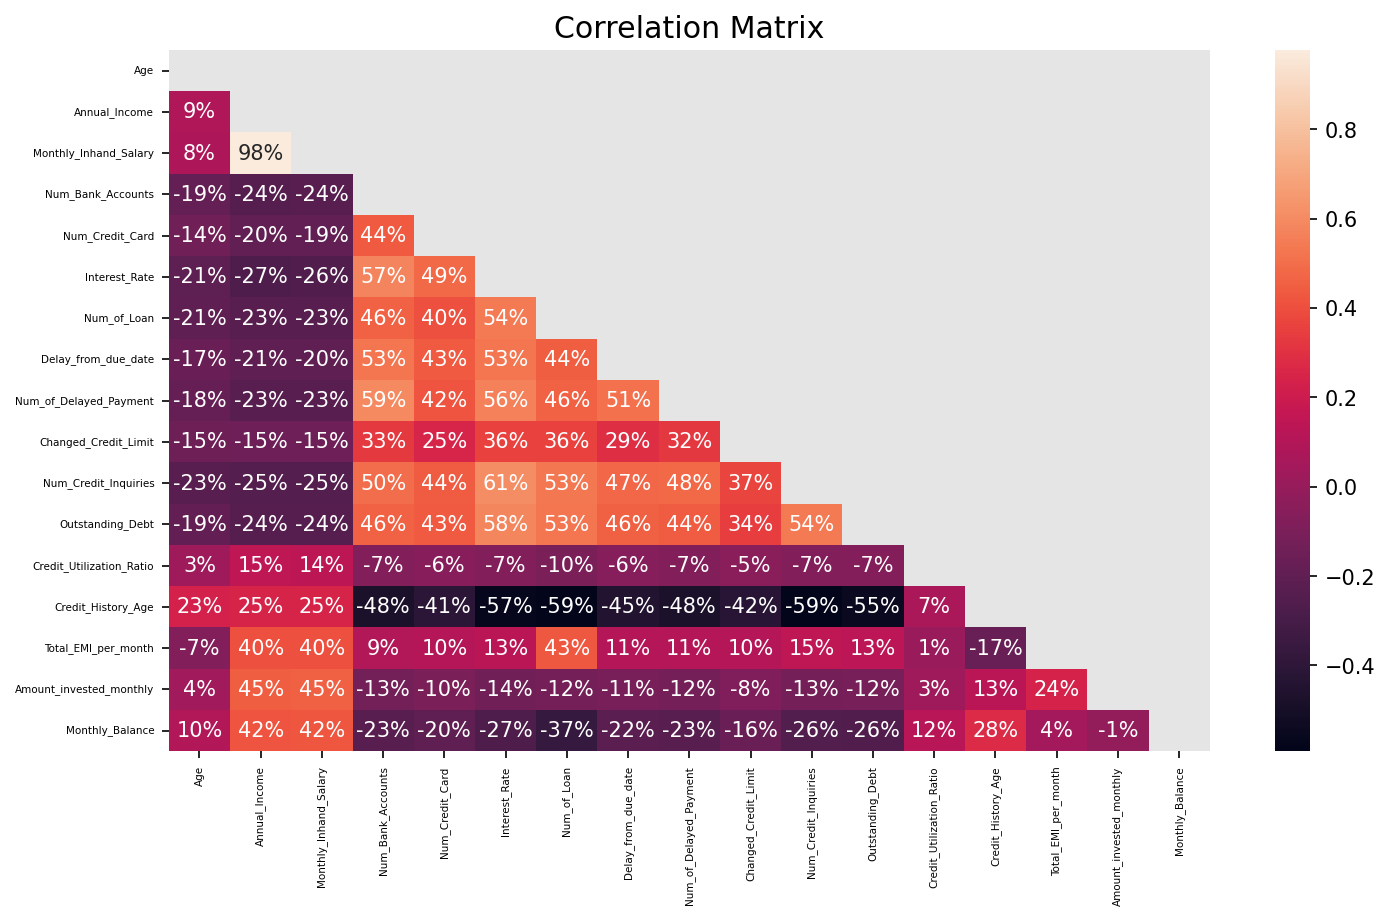

In [59]:
corr = data.drop(["is_train"], axis=1).corr(numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))

fig = plt.figure(figsize=(10, 6), dpi=150)

sns.heatmap(corr, annot=True, mask=mask, fmt=".0%", annot_kws={"size":10})
plt.grid(False)
plt.tick_params(axis="both", labelsize=5)
plt.tight_layout()
plt.title("Correlation Matrix")
plt.show()

In [60]:
df.loc[~df["is_train"], "Month"].value_counts()

Month
September    12500
October      12500
November     12500
December     12500
Name: count, dtype: int64

### Hypothesis Testing with Chi-Square and F-Tests
This Python code defines a chi_2_test function that conducts hypothesis testing to assess the relationship between categorical and numerical columns in a DataFrame and the target variable 'Credit_Score.'

Function Purpose: The chi_2_test function first prepares a copy of the DataFrame with only training data and selects categorical and numerical columns of interest. It then initializes an empty NumPy array to store test results. The function performs two types of tests: Chi-Square tests for categorical columns and F-tests (ANOVA) for numerical columns to assess their significance in explaining 'Credit_Score' variations.

Hypothesis Testing: The Chi-Square test evaluates the independence between categorical variables and 'Credit_Score,' while the F-tests assess the variance in 'Credit_Score' explained by numerical variables. The results include the test statistic and p-value for each column, helping identify significant factors influencing 'Credit_Score.'

This function provides valuable insights into how different features relate to 'Credit_Score,' aiding in feature selection and understanding the dataset's predictive power in credit scoring analysis or modeling.

In [61]:
def chi_2_test(df:pd.DataFrame):
    df_copy = df.loc[df["is_train"]].copy()
    cat_cols = df_copy.select_dtypes(exclude="number").columns.drop(["Customer_ID", "Month", "is_train", "Credit_Score"])
    numb_columns = df_copy.select_dtypes(include="number").columns

    summary = np.empty((len(cat_cols)+len(numb_columns), 3), dtype="object")
    y, *_ = df_copy["Credit_Score"].factorize(sort=False)

    def perform_test(*args, test):

        if test == "chi2":
            for i, col in enumerate(args[0]):
                cross = pd.crosstab(index=df[col], columns=[df["Credit_Score"]])
                t_stat, pvalue, *_ = chi2_contingency(cross)
                summary[i, :] = [col, t_stat, pvalue]

        elif test=="f_classif":
            for i, col in enumerate(args[0], start=len(summary)-len(args[0])):
                t_stat, pvalue = f_classif(df_copy[[col]], y.reshape(-1, 1))
                summary[i, :] = [col, t_stat[0], pvalue[0]]

    perform_test(cat_cols, test="chi2")
    perform_test(numb_columns, test="f_classif")

    return pd.DataFrame(
        data=summary,
        columns=["column", 't-statistic', "p-value"]
    )


In [64]:
chi2_summary = chi_2_test(data).sort_values(by="t-statistic", ascending=False)

chi2_summary.style.bar("t-statistic").background_gradient(
    "Accent", subset="t-statistic")

,column,t-statistic,p-value
1,Type_of_Loan,65283.448081,0.000000
2,Credit_Mix,39939.333264,0.000000
3,Payment_of_Min_Amount,16869.960993,0.000000
10,Interest_Rate,14942.672179,0.000000
15,Num_Credit_Inquiries,11640.610032,0.000000
16,Outstanding_Debt,10172.739505,0.000000
12,Delay_from_due_date,9775.596949,0.000000
9,Num_Credit_Card,9472.156733,0.000000
8,Num_Bank_Accounts,9148.775200,0.000000
18,Credit_History_Age,8902.256599,0.000000


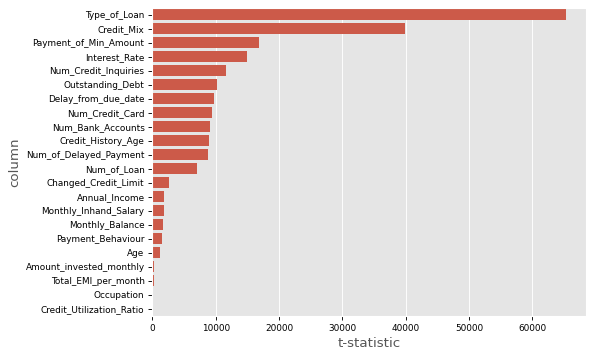

In [65]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.barplot(data=chi2_summary, y="column", x="t-statistic", ax=ax)
plt.setp([ax.get_xticklabels(), ax.get_yticklabels()], size=8)
fig.show()

In [66]:
def transform_columns(data_frame: pd.DataFrame):
    category = data_frame.select_dtypes(exclude="number").columns.tolist()
    number =data_frame.select_dtypes(include="number").columns.tolist()


    def build_pipeline_numb(strategy="median"):
        pipe1 = Pipeline(steps=[
            ("imputer", IterativeImputer(initial_strategy=strategy, random_state=42)),
            ("scaling", MinMaxScaler()),
            # ("pca", PCA(0.98))
            # ("scaling", PowerTransformer())

        ])
        return pipe1

    def build_pipeline_cat(strategy="most_frequent"):
        pipe2 = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy=strategy))
])
        return pipe2

    transformer = ColumnTransformer(
        [
            ("cat_transformer", build_pipeline_cat(), category),
            ("numb_transformer", build_pipeline_numb(), number)
        ],
        remainder="drop"
    )
    transformer.fit(data_frame)
    return transformer


### Data Transformation with Custom Pipelines
This Python code defines a data transformation function, transform_columns, which utilizes custom pipelines for preprocessing categorical and numerical columns in a DataFrame.

Column Selection: The function first identifies categorical and numerical columns within the DataFrame, categorizing them into two separate lists.

Custom Pipelines: It then defines two custom pipelines using scikit-learn's Pipeline class: one for numerical columns and another for categorical columns. The numerical pipeline imputes missing values with the median using IterativeImputer and scales the features to a consistent range using MinMaxScaler. The categorical pipeline imputes missing values with the most frequent value using SimpleImputer.

ColumnTransformer: The pipelines are integrated into a ColumnTransformer object that applies the defined transformations to their respective columns, while the "remainder" parameter specifies that any untransformed columns should be dropped.

This function provides a flexible and structured way to preprocess categorical and numerical data separately, preparing it for downstream analysis or modeling tasks. It allows for customization of imputation strategies and ensures consistent scaling for numerical features.

In [67]:
def split_data(data: pd.DataFrame, test_size=0.2) -> tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
    df_copy = data.copy()
    df_copy.drop(columns = ["Month", "Customer_ID"], inplace=True)
    df_copy["Delay_from_due_date"] = df_copy["Delay_from_due_date"].abs()

    train_set = df_copy[df_copy["is_train"]].drop(["is_train"], axis=1)
    test_set = df_copy[df_copy["is_train"] == False].drop(
        ["is_train", "Credit_Score"], axis=1).reset_index(drop=True)

    X = train_set.drop("Credit_Score", axis=1)
    y = train_set.pop("Credit_Score")

    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=test_size, stratify=y, random_state=2, shuffle=True)
    return ((Xtrain, Xtest, ytrain, ytest), test_set)


def combined_transformers(data, save_to_pickle=False):
    outlier_remover = ClipOutliersTransformer(0.25, 0.75, multiply_by=1.5, replace_with_median=False)
    outlier_remover.fit(data.select_dtypes("number"))
    transformer = transform_columns(data)
    if save_to_pickle:
        file1 = open("OutlierRemover.pkl", "wb")
        file2 = open("ColumnsTransformers.pkl", "wb")
        pickle.dump(outlier_remover, file1)
        pickle.dump(transformer, file2)
    return (outlier_remover, transformer)


def get_transformed_data(data, transformers_to_pkl=False) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    # transformer = kwargs.get("transformer")
    train_set, test_set = split_data(data)
    Xtrain, Xtest, ytrain, ytest = train_set
    _, transformer = combined_transformers(Xtrain, save_to_pickle=transformers_to_pkl)

    columns = list(itertools.chain.from_iterable([transformer[-1] for transformer in transformer.__dict__.get("transformers")]))
    Xtrain = pd.DataFrame(transformer.transform(Xtrain), columns=columns).apply(pd.to_numeric, errors="ignore")
    Xtest = pd.DataFrame(transformer.transform(Xtest), columns=columns).apply(pd.to_numeric, errors="ignore")
    test_set = pd.DataFrame(transformer.transform(test_set), columns=columns).apply(pd.to_numeric, errors="ignore")
    return ((Xtrain, Xtest), (ytrain, ytest), test_set)


In [68]:
((Xtrain, Xtest), (ytrain, ytest), test_set) = get_transformed_data(data, transformers_to_pkl=True)

cat_columns = Xtrain.select_dtypes(exclude="number").columns.drop(["Type_of_Loan"]).tolist()
text_column = ["Type_of_Loan"]

### CatBoost Model Training Functions
These Python functions are designed for training CatBoost models efficiently in machine learning tasks:

create_pool Function: This function prepares training and testing data by creating CatBoost Pools, which are optimized data structures for CatBoost models. It takes input features (xtrain, ytrain, xtest, ytest), categorical features (cat_features), and text features (text_features) as arguments and returns the corresponding CatBoost Pools for training and testing data.

catboost_model Function: This function configures a CatBoostClassifier with default and custom parameters, such as the number of iterations, custom evaluation metrics, and multi-threading settings. Users can provide additional parameters to customize the model further.

fit_model Function: The main training function that combines the previous two functions. It creates the data pools, configures the CatBoost model, fits the model to the training data while evaluating on the testing data, and allows for early stopping and additional keyword arguments.

These functions streamline the process of training CatBoost models, making it easier to handle data preparation, model configuration, and training with customizable options.